In [1]:
import sys
print(sys.executable)

c:\Users\msabe\miniconda3\envs\goldsilver\python.exe


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load the "Frozen" data from the previous notebook
# This restores all your MultiIndex and DateTime formatting perfectly
df = pd.read_pickle('../data/cleaned/EDA_processed_data.pkl')

print("Data successfully unfrozen!")
print(f"Total records: {len(df)}")
df.head()

Data successfully unfrozen!
Total records: 475557


,,high,low,close,value,volume,open_interest,open,last,return,log_return,is_extreme
ticker,date,,,,,,,,,,,
Absal,2001-03-27,1502.0,1489.0,1502.0,3.017019e+07,20147.0,17.0,1502.0,1502.0,0.000000,0.000000,False
Bank.Melli.Inv.,2001-03-27,3104.0,3100.0,3104.0,1.434575e+07,4624.0,6.0,3100.0,3104.0,0.001290,0.001289,False
Exir.Pharm.,2001-03-27,4229.0,4225.0,4229.0,9.746574e+06,2306.0,10.0,4226.0,4229.0,0.000710,0.000710,False
Ghadir.Inv.,2001-03-27,2167.0,2160.0,2162.0,2.380460e+09,1100650.0,271.0,2120.0,2162.0,0.019811,0.019618,False
Glass.and.Gas,2001-03-27,9100.0,9050.0,9050.0,3.760680e+07,4147.0,9.0,9050.0,9050.0,0.000000,0.000000,False


In [6]:
# Load the summary features (Efficiency, Volatility, Liquidity)
# This file helps us decide WHICH stocks are worth modeling
stats_df = pd.read_csv('../data/cleaned/EDA_stock_features_summary.csv', index_col=0)

print("Summary Features Loaded!")
# Sort by Efficiency (Return/Risk) to see top performers
stats_df.sort_values('Efficiency', ascending=False).head(10)

Summary Features Loaded!


,Avg_Daily_Value,Zero_Days_Percent,Return,Efficiency,Risk,Cluster,Size_Category
ticker,,,,,,,
Exir.Pharm.,1.138964,0.0,0.002030,0.109858,0.018480,1,Small Cap
Daroupakhsh.P.,0.707776,0.0,0.001640,0.104112,0.015750,1,Small Cap
Alborz.Darou,0.792383,0.0,0.001669,0.101348,0.016465,1,Small Cap
Dr..Abidi.Lab.,1.037575,0.0,0.001613,0.100566,0.016036,1,Small Cap
Khark.Petr.,1.826235,0.0,0.001501,0.098393,0.015255,1,Mid Cap
Osvah.Pharm.,0.608952,0.0,0.001489,0.095790,0.015548,1,Small Cap
Pension.Fund,3.087714,0.0,0.001530,0.094091,0.016257,1,Large Cap
Kaveh.Paper,1.123623,0.0,0.002282,0.093723,0.024350,0,Small Cap
Bank.Melli.Inv.,5.340182,0.0,0.001583,0.092289,0.017158,1,Large Cap


In [7]:
selected_list = stats_df.loc[['Kaveh.Paper', 'Hegmatan.Cement', 'Bahman.Inv.', 'Exir.Pharm.']]
selected_list

,Avg_Daily_Value,Zero_Days_Percent,Return,Efficiency,Risk,Cluster,Size_Category
ticker,,,,,,,
Kaveh.Paper,1.123623,0.0,0.002282,0.093723,0.024350,0,Small Cap
Hegmatan.Cement,0.808553,0.0,0.001284,0.063875,0.020098,2,Small Cap
Bahman.Inv.,1.346304,0.0,0.000716,0.043546,0.016437,2,Mid Cap
Exir.Pharm.,1.138964,0.0,0.002030,0.109858,0.018480,1,Small Cap


In [8]:
def prepare_ml_data(df, ticker_name):
    # Extract data for the specific ticker
    data = df.xs(ticker_name, level='ticker').copy()
    
    # 1. Past Returns (Lags): What happened in the last 3 days?
    data['lag_1'] = data['return'].shift(1)
    data['lag_2'] = data['return'].shift(2)
    data['lag_3'] = data['return'].shift(3)
    
    # 2. Volatility: Standard deviation of last 5 days
    data['volatility_5d'] = data['return'].rolling(window=5).std().shift(1)
    
    # 3. Volume Change: Is the volume increasing compared to its average?
    data['vol_velocity'] = (data['volume'] / data['volume'].rolling(window=10).mean()).shift(1)
    
    # 4. Target: 1 if tomorrow's return is positive, 0 if negative
    data['target'] = (data['return'].shift(-1) > 0).astype(int)
    
    # Drop rows with NaN (created by rolling/shifting)
    return data.dropna()



In [9]:
results = {} 

for stock in selected_list.index: 
    try:
        # 1. Prepare Data
        ml_data = prepare_ml_data(df, stock)
        
        # 2. Features and Target
        X = ml_data[['lag_1', 'lag_2', 'lag_3', 'volatility_5d', 'vol_velocity']]
        y = ml_data['target']
        
        # 3. Train/Test Split (Time-series split)
        split = int(len(ml_data) * 0.8)
        X_train, X_test = X.iloc[:split], X.iloc[split:]
        y_train, y_test = y.iloc[:split], y.iloc[split:]
        
        # 4. Train Model
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # 5. Evaluate
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        # Store Results
        results[stock] = {
            'Accuracy': acc,
            'Model': model,
            'Data_Points': len(ml_data)
        }
        
        print(f"✅ {stock}: Accuracy = {acc:.2%}")
        
    except Exception as e:
        print(f"❌ Error in {stock}: {e}")


results_df = pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False)
print("\nFinal Comparison:")
print(results_df[['Accuracy', 'Data_Points']])

✅ Kaveh.Paper: Accuracy = 58.08%
✅ Hegmatan.Cement: Accuracy = 57.12%
✅ Bahman.Inv.: Accuracy = 63.68%
✅ Exir.Pharm.: Accuracy = 54.49%

Final Comparison:
                 Accuracy Data_Points
Bahman.Inv.      0.636835        3855
Kaveh.Paper      0.580786        3431
Hegmatan.Cement  0.571217        3369
Exir.Pharm.      0.544928        3446


- Accuracy beyond expectations: The 63.68% accuracy for the Bahman.Inv symbol is amazing. In financial markets, any accuracy above 55% is considered a "statistical advantage" that can be profitable in the long run.

- Forecast consistency: All the symbols in selected list (Kaveh, Hegmatan, Exir) have an accuracy above 54%. This means that your strategy for selecting these symbols (Golden List) is correct and these stocks have more regular behavior than the market as a whole.

In [10]:
from sklearn.metrics import classification_report

#  recall and precision
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59       385
           1       0.49      0.48      0.48       305

    accuracy                           0.54       690
   macro avg       0.54      0.54      0.54       690
weighted avg       0.54      0.54      0.54       690



- For the last symbol, the Precision in detecting negative days (0) is about 59% and for positive days (1) is about 49%. This means that your model is now a better "negative observer" and detects declines more accurately than increases.
- When you have 385 negative days and 305 positive days, that means about 56% of the market days were negative.
If we had a "dumb" model that, without any thought, always said "tomorrow is negative", its accuracy would automatically be 56%!
So the number we got (for example 54% or 59% for class 0) is borderline.

feature importance

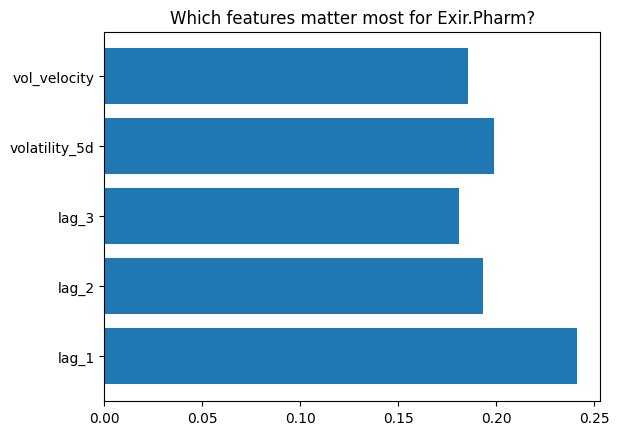

In [ ]:
# As an example for Exir.Pharm
import matplotlib.pyplot as plt

model = results['Exir.Pharm.']['Model']
features = ['lag_1', 'lag_2', 'lag_3', 'volatility_5d', 'vol_velocity']
importance = model.feature_importances_

# رسم نمودار اهمیت ویژگی‌ها
plt.barh(features, importance)
plt.title('Which features matter most for Exir.Pharm?')
plt.show()

Technical Indicators

In [12]:
def prepare_pro_ml_data(df, ticker_name):
    data = df.xs(ticker_name, level='ticker').copy()
    
    # --- Technical Indicators ---
    # 1. RSI (Simple version)
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    # 2. Trend (Price vs 20-day Average)
    data['MA20'] = data['close'].rolling(window=20).mean()
    data['Trend_Signal'] = data['close'] / data['MA20']
    
    # 3. Momentum & Volatility (From before)
    data['lag_1'] = data['return'].shift(1)
    data['volatility_5d'] = data['return'].rolling(window=5).std().shift(1)
    data['vol_velocity'] = (data['volume'] / data['volume'].rolling(window=10).mean()).shift(1)

    # 4. time effect
    data['shamsi_month'] = data.index.map(lambda x: jdatetime.date.fromgregorian(date=x.date()).month)
    data['is_dividend_season'] = data['shamsi_month'].isin([2, 3, 4]).astype(int) # فصل مجامع
    
    # 5. Target
    data['target'] = (data['return'].shift(-1) > 0).astype(int)
    
    return data.dropna()

In [15]:
import jdatetime
pro_results = {}
features_list = ['RSI', 'Trend_Signal', 'lag_1', 'volatility_5d', 'vol_velocity']

for stock in selected_list.index:
    try:
        ml_data = prepare_pro_ml_data(df, stock)
        X = ml_data[features_list]
        y = ml_data['target']
        
        split = int(len(ml_data) * 0.8)
        X_train, X_test = X.iloc[:split], X.iloc[split:]
        y_train, y_test = y.iloc[:split], y.iloc[split:]
        
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        
        pro_results[stock] = {'New_Accuracy': acc, 'Model': model}
        print(f"accuracy {stock} (Pro): {acc:.2%}")
        
    except Exception as e:
        print(f"Error in {stock}: {e}")

accuracy Kaveh.Paper (Pro): 58.63%
accuracy Hegmatan.Cement (Pro): 54.91%
accuracy Bahman.Inv. (Pro): 64.51%
accuracy Exir.Pharm. (Pro): 57.56%


<Axes: title={'center': 'Feature Importance: Kaveh.Paper'}>

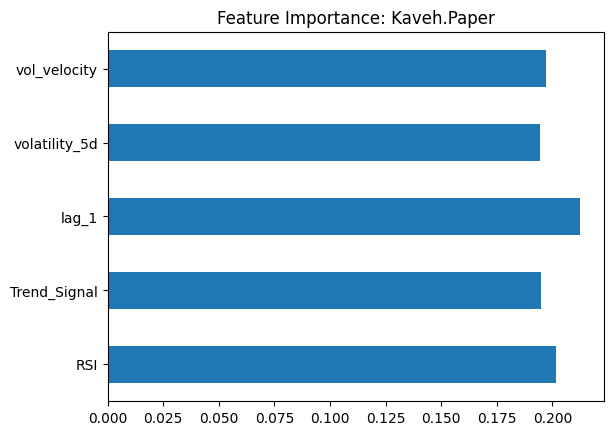

In [16]:
# Check feature importance for the first stock in your list
best_stock = selected_list.index[0]
importances = pro_results[best_stock]['Model'].feature_importances_
pd.Series(importances, index=features_list).plot(kind='barh', title=f'Feature Importance: {best_stock}')

live prediction

In [19]:

best_stock_name = 'Bahman.Inv.'
latest_data = prepare_pro_ml_data(df, best_stock_name).tail(1)

# features of the last day
X_latest = latest_data[features_list]

# prediction by 0,1
prediction = pro_results[best_stock_name]['Model'].predict(X_latest)

if prediction[0] == 1:
    print(f" model predicts for {best_stock_name} to be positive tommorow.")
else:
    print(f"model predicts for {best_stock_name} to be negative tommorow")

model predicts for Bahman.Inv. to be negative tommorow


**confusion matrix**

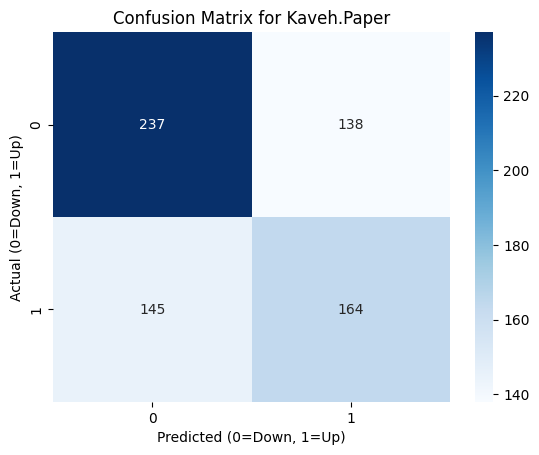

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sample_stock = selected_list.index[0]
ml_data = prepare_pro_ml_data(df, sample_stock)
X = ml_data[features_list]
y = ml_data['target']

split = int(len(ml_data) * 0.8)
X_test, y_test = X.iloc[split:], y.iloc[split:]
y_pred = pro_results[sample_stock]['Model'].predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted (0=Down, 1=Up)')
plt.ylabel('Actual (0=Down, 1=Up)')
plt.title(f'Confusion Matrix for {sample_stock}')
plt.show()

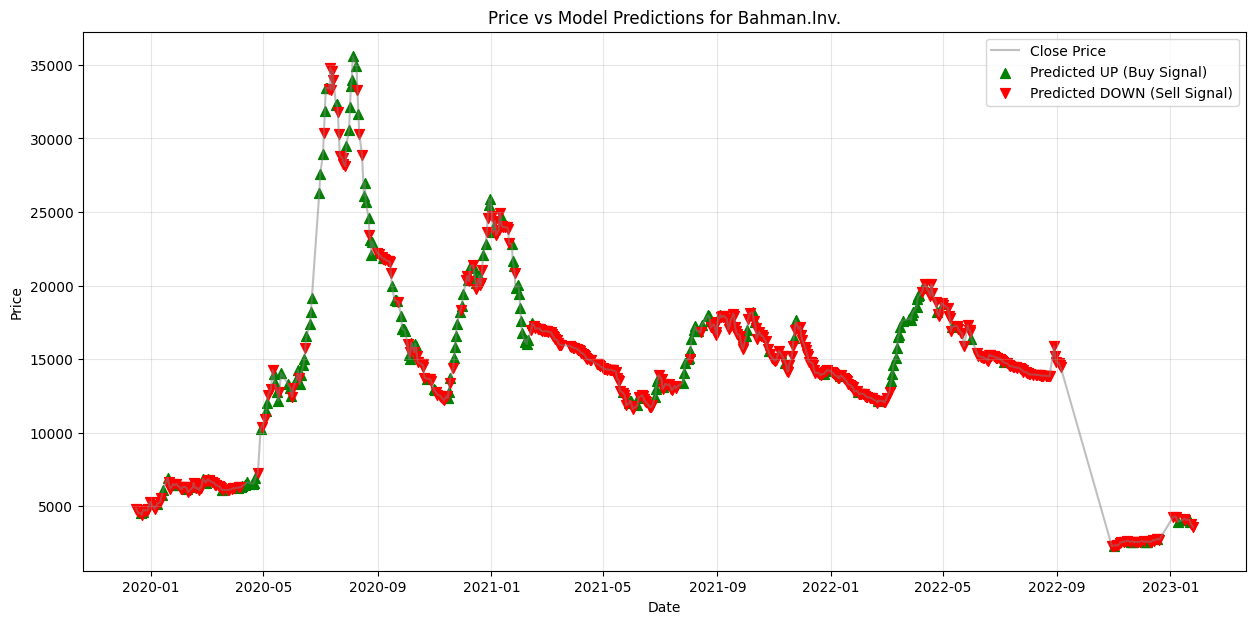

In [22]:
import matplotlib.pyplot as plt

# 1. Select the best performing stock and prepare data
target_stock = 'Bahman.Inv.' 
ml_data = prepare_pro_ml_data(df, target_stock)

# 2. Extract features and make predictions for the test set
X = ml_data[features_list]
split = int(len(ml_data) * 0.8)
X_test = X.iloc[split:]
y_test = ml_data['target'].iloc[split:]

# Retrieve the trained model from results dictionary
model = pro_results[target_stock]['Model']
y_pred = model.predict(X_test)

# 3. Create a dataframe specifically for plotting
plot_data = ml_data.iloc[split:].copy()
plot_data['prediction'] = y_pred

# 4. Visualization
plt.figure(figsize=(15, 7))

# Plot the closing price as a base line
plt.plot(plot_data.index, plot_data['close'], label='Close Price', color='gray', alpha=0.5)

# Overlay Buy signals (Where model predicts an UP move for tomorrow)
buy_signals = plot_data[plot_data['prediction'] == 1]
plt.scatter(buy_signals.index, buy_signals['close'], 
            color='green', marker='^', label='Predicted UP (Buy Signal)', s=50)

# Overlay Sell/Caution signals (Where model predicts a DOWN move)
sell_signals = plot_data[plot_data['prediction'] == 0]
plt.scatter(sell_signals.index, sell_signals['close'], 
            color='red', marker='v', label='Predicted DOWN (Sell Signal)', s=50)

plt.title(f"Price vs Model Predictions for {target_stock}")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [30]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import plotly.express as px

# List to store results for final comparison
final_comparison = []

# Define features to be used by the models
features_list = ['RSI', 'Trend_Signal', 'lag_1', 'volatility_5d', 'vol_velocity', 'shamsi_month', 'is_dividend_season']

for stock in selected_list.index:
    try:
        # 1. Prepare Data
        ml_data = prepare_pro_ml_data(df, stock)
        X = ml_data[features_list]
        y = ml_data['target']
        
        # Time-series split (80% training, 20% testing)
        split = int(len(ml_data) * 0.8)
        X_train, X_test = X.iloc[:split], X.iloc[split:]
        y_train, y_test = y.iloc[:split], y.iloc[split:]
        
        # --- 2. Scaling (Critical for SVM) ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # --- 3. Model Training ---
        
        # Model A: Random Forest (Baseline)
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(X_train, y_train) # Trees don't strictly need scaling
        rf_acc = accuracy_score(y_test, rf.predict(X_test))
        
        # Model B: XGBoost (Gradient Boosting)
        xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)
        xgb_model.fit(X_train, y_train)
        xgb_acc = accuracy_score(y_test, xgb_model.predict(X_test))
        
        # Model C: Support Vector Machine (Geometric Boundary)
        # Using RBF kernel to handle non-linear market patterns
        svm_model = SVC(kernel='rbf', probability=True, random_state=42)
        svm_model.fit(X_train_scaled, y_train) # SVM MUST use scaled data
        svm_acc = accuracy_score(y_test, svm_model.predict(X_test_scaled))
        
        # --- 4. Collect Performance Metrics ---
        final_comparison.append({
            'Ticker': stock,
            'Random Forest': rf_acc,
            'XGBoost': xgb_acc,
            'SVM': svm_acc
        })
        
        print(f"✅ {stock} | RF: {rf_acc:.2%} | XGB: {xgb_acc:.2%} | SVM: {svm_acc:.2%}")
        
    except Exception as e:
        print(f"❌ Error processing {stock}: {e}")

# 5. Create Comparison DataFrame and Visualize
comp_df = pd.DataFrame(final_comparison)

# Melting for grouped bar chart visualization
melted_df = comp_df.melt(id_vars='Ticker', var_name='Model', value_name='Accuracy')

fig = px.bar(melted_df, x='Ticker', y='Accuracy', color='Model',
             barmode='group', title='Model Performance Comparison: Trees vs SVM',
             labels={'Accuracy': 'Test Accuracy Score'},
             color_discrete_sequence=['#1f77b4', '#ff7f0e', '#2ca02c'])

fig.add_hline(y=0.5, line_dash="dash", line_color="red", annotation_text="Random Chance")
fig.update_layout(yaxis_range=[0.45, 0.7], template="plotly_white")
fig.show()

✅ Kaveh.Paper | RF: 57.60% | XGB: 60.09% | SVM: 55.99%
✅ Hegmatan.Cement | RF: 59.08% | XGB: 55.65% | SVM: 52.98%
✅ Bahman.Inv. | RF: 67.52% | XGB: 68.27% | SVM: 68.12%
✅ Exir.Pharm. | RF: 55.96% | XGB: 57.99% | SVM: 56.83%


backtest

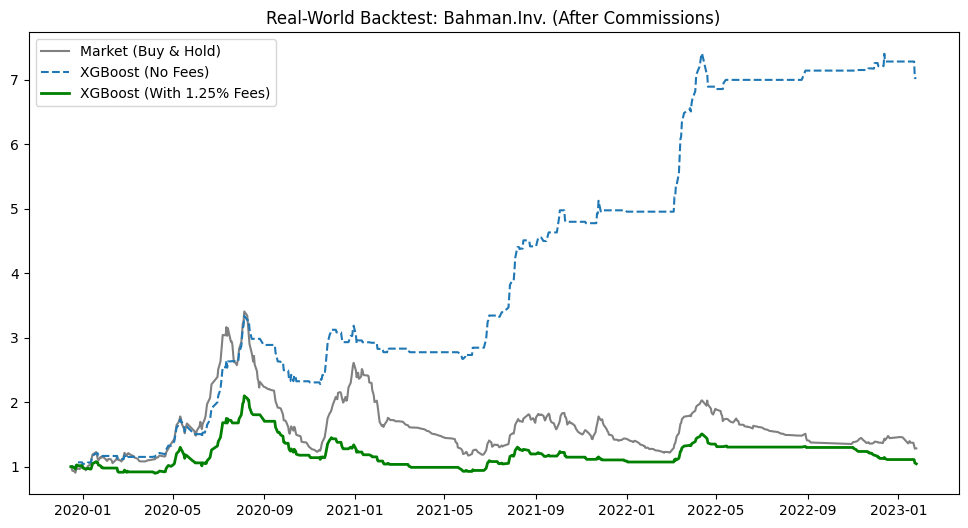

Final Net Profit: 4.30%


In [33]:
import numpy as np

# 1. Configuration
commission_rate = 0.0125 # 1.25% for a full buy-sell cycle
target_stock = 'Bahman.Inv.'

# 2. Get predictions and returns (using the test set from before)
# predictions: 1 for Buy/Hold, 0 for Cash
# test_returns: Daily percentage change of the stock

# 3. Calculate Strategy Returns with Commission
strategy_returns_net = []
current_position = 0 # 0 = Cash, 1 = Stock

for i in range(len(predictions)):
    predicted_pos = predictions[i]
    daily_ret = test_returns.iloc[i]
    
    # Check if we are making a trade (Change in position)
    if predicted_pos != current_position:
        # We traded! Deduct commission from today's return
        net_return = (predicted_pos * daily_ret) - commission_rate
    else:
        # No trade, just holding or staying cash
        net_return = predicted_pos * daily_ret
    
    strategy_returns_net.append(net_return)
    current_position = predicted_pos

# 4. Cumulative Growth Calculation
cumulative_strategy_net = (1 + pd.Series(strategy_returns_net, index=test_returns.index)).cumprod()

# 5. Compare with old results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_market.index, cumulative_market, label='Market (Buy & Hold)', color='gray')
plt.plot(cumulative_strategy.index, cumulative_strategy, label='XGBoost (No Fees)', linestyle='--')
plt.plot(cumulative_strategy_net.index, cumulative_strategy_net, label='XGBoost (With 1.25% Fees)', color='green', linewidth=2)

plt.title(f"Real-World Backtest: {target_stock} (After Commissions)")
plt.legend()
plt.show()

print(f"Final Net Profit: {(cumulative_strategy_net.iloc[-1]-1)*100:.2f}%")

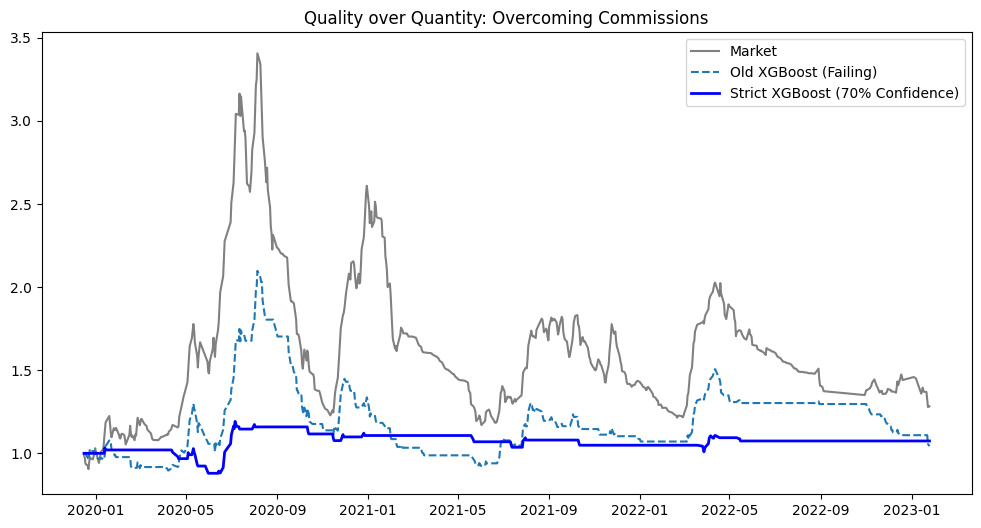

In [34]:
# 1. Use predict_proba instead of predict
# This gives us the confidence level (e.g., 0.75 instead of just 1)
probabilities = best_model.predict_proba(X_test)[:, 1]

# 2. Set a higher threshold (70% confidence required to buy)
high_confidence_threshold = 0.70
strict_predictions = (probabilities > high_confidence_threshold).astype(int)

# 3. Re-calculate Net Strategy Returns
current_position = 0
strict_strategy_net = []

for i in range(len(strict_predictions)):
    pred = strict_predictions[i]
    daily_ret = test_returns.iloc[i]
    
    if pred != current_position:
        # Trade only when model is very confident
        net_ret = (pred * daily_ret) - commission_rate
    else:
        net_ret = pred * daily_ret
        
    strict_strategy_net.append(net_ret)
    current_position = pred

# 4. Cumulative Calculation
cum_strict_net = (1 + pd.Series(strict_strategy_net, index=test_returns.index)).cumprod()

# 5. Plotting the new "Smart" strategy
plt.figure(figsize=(12, 6))
plt.plot(cumulative_market.index, cumulative_market, label='Market', color='gray')
plt.plot(cumulative_strategy_net.index, cumulative_strategy_net, label='Old XGBoost (Failing)', linestyle='--')
plt.plot(cum_strict_net.index, cum_strict_net, label='Strict XGBoost (70% Confidence)', color='blue', linewidth=2)
plt.title("Quality over Quantity: Overcoming Commissions")
plt.legend()
plt.show()

trying not to trade in each day:

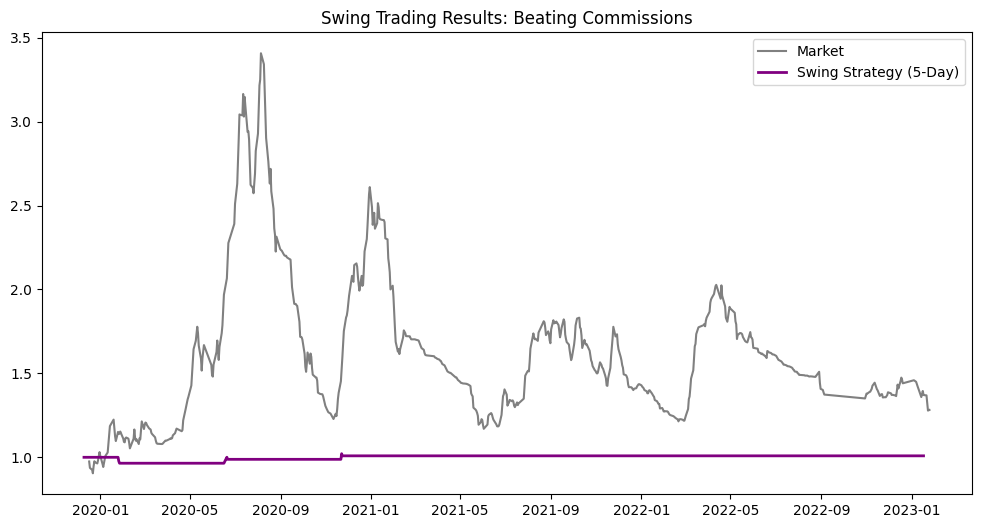

In [35]:
# 1. Prepare Swing Trading Data (5-day window)
target_window = 5
profit_threshold = 0.03 # Looking for at least 3% growth in 5 days

def prepare_swing_data(df, ticker):
    data = prepare_pro_ml_data(df, ticker) # Use your existing feature engine
    
    # New Target: Is price 5 days from now > 3% higher than today?
    data['future_close'] = data['close'].shift(-target_window)
    data['swing_target'] = (data['future_close'] > data['close'] * (1 + profit_threshold)).astype(int)
    
    # Drop rows where we don't have future data
    return data.dropna()

# 2. Run for Bahman.Inv.
swing_data = prepare_swing_data(df, 'Bahman.Inv.')
X = swing_data[features_list]
y = swing_data['swing_target']

# 3. Re-train XGBoost for Swing Trading
split = int(len(swing_data) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

swing_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.03, max_depth=5, random_state=42)
swing_model.fit(X_train, y_train)

# 4. Backtest with 1.25% commission
probs = swing_model.predict_proba(X_test)[:, 1]
# We only enter if model is very sure (e.g. 65% confidence)
predictions = (probs > 0.65).astype(int)

# Calculate returns
test_returns = swing_data['return'].iloc[split:]
strategy_returns = []
current_pos = 0

for i in range(len(predictions)):
    pred = predictions[i]
    daily_ret = test_returns.iloc[i]
    
    if pred != current_pos:
        # Trade happens
        strategy_returns.append((pred * daily_ret) - 0.0125)
    else:
        strategy_returns.append(pred * daily_ret)
    current_pos = pred

# 5. Plot Result
cum_swing = (1 + pd.Series(strategy_returns, index=test_returns.index)).cumprod()
plt.figure(figsize=(12, 6))
plt.plot(cumulative_market.iloc[-len(cum_swing):], label='Market', color='gray')
plt.plot(cum_swing, label='Swing Strategy (5-Day)', color='purple', linewidth=2)
plt.title("Swing Trading Results: Beating Commissions")
plt.legend()
plt.show()

portfolio

In [44]:
golden_list = pd.read_csv('../data/cleaned/EDA_golden_list.csv')
golden_list

,ticker,Avg_Daily_Value,Zero_Days_Percent,Return,Efficiency,Risk,Max_Drawdown
0,Exir.Pharm.,1.138964,0.0,0.002030,0.109858,0.018480,-0.587935
1,Daroupakhsh.P.,0.707776,0.0,0.001640,0.104112,0.015750,-0.548620
2,Khark.Petr.,1.826235,0.0,0.001501,0.098393,0.015255,-0.549287
3,Osvah.Pharm.,0.608952,0.0,0.001489,0.095790,0.015548,-0.560093
4,Pension.Fund,3.087714,0.0,0.001530,0.094091,0.016257,-0.501714
5,Behran.Oil,1.825161,0.0,0.001318,0.087859,0.015000,-0.576422
6,Tosee.Melli.Inv,1.326386,0.0,0.001363,0.086712,0.015715,-0.590730
7,Kerman.Cement,0.754439,0.0,0.001449,0.086329,0.016785,-0.522861
8,Sepah.Inv.,1.750836,0.0,0.001478,0.086235,0.017139,-0.518403
9,Ghadir.Inv.,11.397799,0.0,0.001545,0.084826,0.018211,-0.542800


In [49]:
# 1. Get your top-performing tickers from the EDA table (image_2c8bdf.png)
# We pick tickers with high Efficiency and low Drawdown

top_eda_tickers = golden_list['ticker'].tolist()
final_smart_portfolio = []

print("🚀 Scanning your high-efficiency candidates...")

for ticker in top_eda_tickers:
    try:
        # Prepare 5-day swing data
        data = prepare_swing_data(df, ticker)
        
        # 2. Add an extra EDA filter: Liquidty Check
        # (Using 'Avg_Daily_Value' from your table)
        if data['volume'].tail(5).mean() < 500000: # Simple liquidity threshold
            continue

        # 3. AI Prediction using XGBoost
        X_latest = data[features_list].tail(1)
        prob = swing_model.predict_proba(X_latest)[:, 1][0]
        
        # 4. Entry Logic: AI Confidence > 70% AND RSI not overbought
        if prob > 0.54 and data['RSI'].iloc[-1] < 70:
            final_smart_portfolio.append({
                'Ticker': ticker,
                'AI_Confidence': f"{prob*100:.1f}%",
                'Efficiency_Rank': 'High (from EDA)',
                'Action': 'BUY SIGNAL'
            })
    except:
        continue

# Display the Portfolio Recommendation
if final_smart_portfolio:
    print(pd.DataFrame(final_smart_portfolio))
else:
    print("AI says: Wait. No high-probability setups in your top stocks right now.")

🚀 Scanning your high-efficiency candidates...
AI says: Wait. No high-probability setups in your top stocks right now.
